In [1]:
"""Resnet model for classification of real and fake images. - Gray Version"""
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import PIL as image_lib
import tensorflow as tflow
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plotter_lib
import numpy as np
import PIL as image_lib
import tensorflow as tflow
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import time
import gc
from PIL import Image

In [2]:
AUTOTUNE = tflow.data.AUTOTUNE
# Set up the image size, this is the default for ResNet50

IMAGE_SIZE = (256, 256)  # height, width
batch_size = 128  # 32 is default recommendation for vision models

In [3]:
train_ds = tflow.keras.preprocessing.image_dataset_from_directory(
    "T9-GrayTrain",
    label_mode="binary",
    # validation_split=val_ratio,
    shuffle=True,
    # subset="training",
    seed=417,
    image_size=IMAGE_SIZE,
    batch_size=batch_size,  # Changed from batch_size 32 to none
    # color_mode="grayscale",
)

validation_ds = tflow.keras.preprocessing.image_dataset_from_directory(
    "T9-GrayVal",
    # validation_split=val_ratio,
    shuffle=True,
    # subset="validation",
    seed=417,
    label_mode="binary",
    image_size=IMAGE_SIZE,
    batch_size=batch_size,  # Changed from batch_size 32 to none
    # color_mode="grayscale",
)

train_ds_and_val_ds = train_ds.concatenate(validation_ds)

Found 100796 files belonging to 2 classes.
Found 11200 files belonging to 2 classes.


In [4]:
count = 0
img_gs = []
label_gs = []
for img, label in train_ds_and_val_ds.take(-1):
    count += 1
    img_gs.append(img.numpy())
    label_gs.append(label.numpy())

print(f"Number of batches in TrainplusVal: {count}")
train_ds_and_val_ds.shuffle(count, reshuffle_each_iteration=False)
del count, img_gs, label_gs
gc.collect()

Number of batches in TrainplusVal: 876


0

In [5]:
test_ds = tflow.keras.preprocessing.image_dataset_from_directory(
    "T9-GrayTest",
    label_mode="binary",
    shuffle=True,
    seed=417,
    image_size=IMAGE_SIZE,
    batch_size=batch_size,  # Changed from batch_size 32 to none
    # color_mode="grayscale",
)

Found 28000 files belonging to 2 classes.


In [6]:
epochs = 10
# Model creation
# Load the model

demo_resnet_model = tflow.keras.models.load_model("demo_resnet_model_140KGray.h5")
demo_resnet_model.summary()
demo_resnet_model.get_config()
demo_resnet_model.get_weights()
demo_resnet_model.optimizer
demo_resnet_model.loss
demo_resnet_model.metrics
# Our model has been validated

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
history = demo_resnet_model.fit(
    train_ds_and_val_ds,
    # validation_data=validation_ds,
    epochs=epochs,
    verbose=1,
    shuffle=False,  # For reproducibility
    # callbacks=[tflow.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
)

Epoch 1/10
876/876 [==============================] - 304s 339ms/step - loss: 0.0805 - accuracy: 0.9708 - auc: 0.9955 - precision: 0.9727 - recall: 0.9688 - true_positives: 54252.0000 - true_negatives: 54476.0000 - false_positives: 1521.0000 - false_negatives: 1747.0000
Epoch 2/10
876/876 [==============================] - 300s 342ms/step - loss: 0.0766 - accuracy: 0.9712 - auc: 0.9960 - precision: 0.9730 - recall: 0.9694 - true_positives: 54287.0000 - true_negatives: 54489.0000 - false_positives: 1508.0000 - false_negatives: 1712.0000
Epoch 3/10
876/876 [==============================] - 301s 343ms/step - loss: 0.0644 - accuracy: 0.9765 - auc: 0.9972 - precision: 0.9788 - recall: 0.9742 - true_positives: 54555.0000 - true_negatives: 54814.0000 - false_positives: 1183.0000 - false_negatives: 1444.0000
Epoch 4/10
876/876 [==============================] - 300s 343ms/step - loss: 0.0586 - accuracy: 0.9786 - auc: 0.9976 - precision: 0.9803 - recall: 0.9767 - true_positives: 54696.0000 - t

In [14]:
demo_resnet_model.save("demo_resnet_model_140K_tr_val_rgb.h5")
demo_resnet_model.save_weights("demo_resnet_model_140K_tr_val_rgb_weights.h5")

In [15]:
ims = []
labs = []
probs = []
preds = []
for image, label in test_ds:
    ims.append(image)
    labs.append(label)
    probs.append(demo_resnet_model.predict(image))
    preds.append(np.round(demo_resnet_model.predict(image)))

ims = np.concatenate(ims, axis=0)
labs = np.concatenate(labs, axis=0)
probs = np.concatenate(probs, axis=0)
preds = np.concatenate(preds, axis=0)
misclassifieds = np.where(labs != preds)[0]
misc_ims = ims[misclassifieds]
misc_labs = labs[misclassifieds]
im_labels = zip(misc_ims, misc_labs)
iter_for_name = 0
for im, lab in im_labels:
    if lab == 0:
        flag = "Fake"
    else:
        flag = "Real"
    reconstructed_image = Image.fromarray((im * 1).astype(np.uint8)).convert("RGB")
    # use old ind for naming
    reconstructed_image.save(f"T9-Misc140KGray\{flag}\{flag}{iter_for_name}.png")
    iter_for_name += 1

print(f"Number of misclassified images in the test set: {len(misc_labs)}")

3/3 [==============================] - 0s 83ms/step
Number of misclassified images in the test set: 1743


In [16]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(labs, preds))
print(confusion_matrix(labs, preds))
# write classification report to file

with open("Graytest_classification_report.txt", "w") as f:
    f.write(str(classification_report(labs, preds)))
    f.close()
# write confusion matrix to file

with open("Graytest_confusion_matrix.txt", "w") as f:
    f.write(str(confusion_matrix(labs, preds)))
    f.close()

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94     14000
         1.0       0.97      0.90      0.94     14000

    accuracy                           0.94     28000
   macro avg       0.94      0.94      0.94     28000
weighted avg       0.94      0.94      0.94     28000

[[13608   392]
 [ 1351 12649]]


In [17]:
evaluation = demo_resnet_model.evaluate(test_ds, verbose=1, return_dict=True)
print(evaluation)
# write evaluation to file

with open("Graytest_evaluation.txt", "w") as f:
    f.write(str(evaluation))
    f.write(str(test_ds.class_names))
    f.close()

219/219 [==============================] - 77s 345ms/step - loss: 0.2080 - accuracy: 0.9378 - auc: 0.9824 - precision: 0.9699 - recall: 0.9036 - true_positives: 12650.0000 - true_negatives: 13608.0000 - false_positives: 392.0000 - false_negatives: 1350.0000
{'loss': 0.20802031457424164, 'accuracy': 0.9377856850624084, 'auc': 0.9823802709579468, 'precision': 0.9699432849884033, 'recall': 0.9035714268684387, 'true_positives': 12650.0, 'true_negatives': 13608.0, 'false_positives': 392.0, 'false_negatives': 1350.0}


In [18]:
import matplotlib.pyplot as plotter_lib
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np

In [19]:
def roc_curve_T9(labels_ls, test_ds_pred):
    fpr, tpr, _ = roc_curve(labels_ls, test_ds_pred)
    auc_score = auc(fpr, tpr)
    # plot roc curve
    plotter_lib.plot(
        fpr,
        tpr,
        color="orange",
        label=f"ResNet50 (AUC = {auc_score:.4f})",
    )
    # axis labels
    # add random guessing line
    plotter_lib.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plotter_lib.xlabel("False Positive Rate")
    plotter_lib.ylabel("True Positive rate")
    plotter_lib.legend(loc="best")
    plotter_lib.title("ROC Curve on Test Set - GrayScale")
    plotter_lib.show()

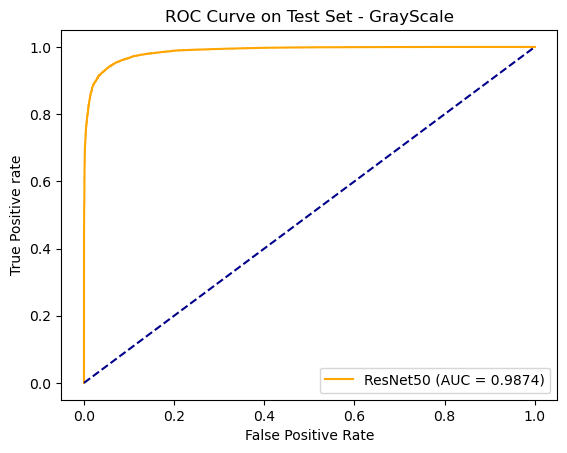

In [20]:
roc_curve_T9(labs, probs)

In [21]:
def pr_curve_T9(labels_ls, test_ds_pred):
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(labels_ls[labels_ls == 1]) / len(labels_ls)
    # calculate model precision-recall curve
    precision, recall, _ = precision_recall_curve(labels_ls, test_ds_pred)
    # average precision score
    ap = average_precision_score(labels_ls, test_ds_pred)
    # plot the precision-recall curves
    plotter_lib.plot(
        [0, 1], [no_skill, no_skill], linestyle="--", label="Random Chance"
    )
    plotter_lib.plot(recall, precision, label="ResNet50 (AP = %.4f)" % ap)
    # axis labels
    plotter_lib.xlabel("Recall")
    plotter_lib.ylabel("Precision")
    plotter_lib.title("Precision-Recall Curve on Test Set - GrayScale")
    plotter_lib.legend()
    plotter_lib.show()

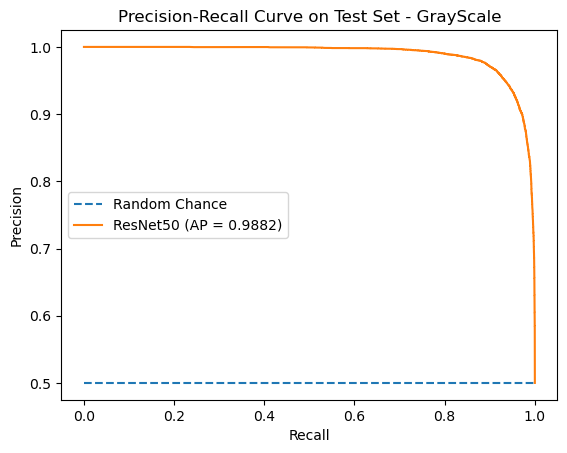

In [22]:
pr_curve_T9(labs, probs)

In [23]:
demo_resnet_model.save("demo_resnet_model_140K_tr_val_rgb.h5")
demo_resnet_model.save_weights("demo_resnet_model_140K_tr_val_rgb_weights.h5")

In [24]:
all_ds = train_ds_and_val_ds.concatenate(test_ds)
# validating the number of images in the dataset

count = 0
for im, label in all_ds.take(-1):
    count += im.shape[0]

print("The images in the dataset with all the data are: ", count)

The images in the dataset with all the data are:  139996


In [25]:
final_history = demo_resnet_model.fit(
    all_ds,
    # validation_data=validation_ds,
    epochs=epochs,
    verbose=1,
    shuffle=False,  # For reproducibility
    # callbacks=[tflow.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
)

Epoch 1/10
1095/1095 [==============================] - 374s 340ms/step - loss: 0.0642 - accuracy: 0.9774 - auc: 0.9967 - precision: 0.9785 - recall: 0.9762 - true_positives: 68332.0000 - true_negatives: 68495.0000 - false_positives: 1502.0000 - false_negatives: 1667.0000
Epoch 2/10
1095/1095 [==============================] - 371s 339ms/step - loss: 0.0560 - accuracy: 0.9799 - auc: 0.9975 - precision: 0.9809 - recall: 0.9790 - true_positives: 68528.0000 - true_negatives: 68660.0000 - false_positives: 1337.0000 - false_negatives: 1471.0000
Epoch 3/10
1095/1095 [==============================] - 372s 340ms/step - loss: 0.0465 - accuracy: 0.9831 - auc: 0.9983 - precision: 0.9837 - recall: 0.9825 - true_positives: 68775.0000 - true_negatives: 68855.0000 - false_positives: 1142.0000 - false_negatives: 1224.0000
Epoch 4/10
1095/1095 [==============================] - 372s 339ms/step - loss: 0.0424 - accuracy: 0.9844 - auc: 0.9986 - precision: 0.9854 - recall: 0.9834 - true_positives: 68840.

In [26]:
demo_resnet_model.save("deploy_resnet_model_140K_alldata_gray.h5")
demo_resnet_model.save_weights("deploy_resnet_model_140K_alldata_gray_weights.h5")